In [5]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


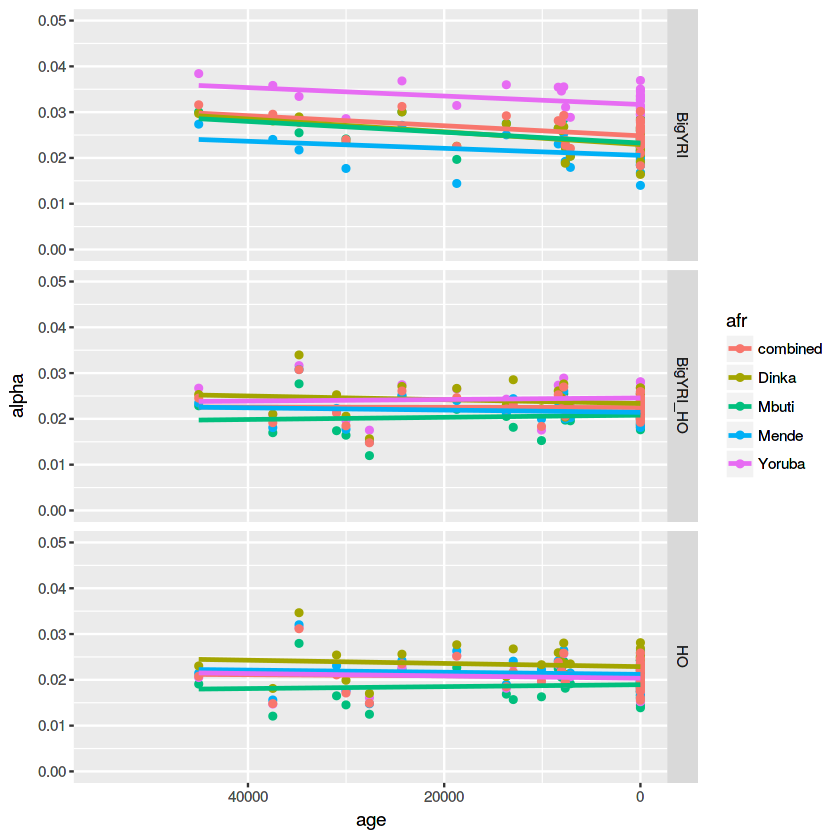

In [20]:
bind_rows(
    readRDS("../data/RData/admixtools_nea_ancestry-both_arrays.rds"),
    readRDS("../data/RData/admixtools_nea_ancestry-BigYRI.rds"),
    readRDS("../data/RData/admixtools_nea_ancestry-HO.rds"),
) %>%
filter(setup != "qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp") %>%
mutate(afr=str_replace_all(setup, "qpF4ratio__new_Altai_new_Vindija_", "") %>% str_replace_all("_Chimp", "")) %>% 
mutate(afr=str_replace(afr, "Africans", "combined")) %>% 
ggplot(aes(age, alpha, color=afr)) +
    geom_point() +
    geom_smooth(method="lm", se=FALSE) +
    xlim(55000, 0) + ylim(0, 0.05) +
    facet_grid(sites ~ .)